# Remote data

In this lesson we explore tools and components to interact with 
remote geospatial web-services to fetch information and geospatial data.

## OWSLib - Python client for OGC OWS

[OWSlib](https://owslib.readthedocs.io) is 
a client implemented in Python for Web Services standardized by the [Open Geospatial Consortium](https://www.ogc.org/)
hence often nicknamed "OGC OWS".
 
`OWSLib` enables you to connect to these services as 
a client, mainly to fetch and query data from them. 
Currently WMS, WFS, WCS, CSW, WPS, SOS, WMC and the more recent OGC APIs like 
*OGC API - Features* (formerly called "WFS version 3") are supported.
The list of supported services is growing. 

Documentation: https://owslib.readthedocs.io


## Interact with a WMS

OGC Web Map Service (WMS) can be used to download map images rendered by the remote server.

### GetCapabilities
This is the metadata of the service endpoint (thanks to our friends at Terrestris).

In [1]:
from owslib.wms import WebMapService

wms_url = 'https://ows.terrestris.de/osm/service'

wms = WebMapService(wms_url, version="1.3.0")

print(f'WMS title: {wms.identification.title}')

print(f'WMS abstract: {wms.identification.abstract}')

print(f'Provider name: {wms.provider.name}')

print(f'Provider address: {wms.provider.contact.address}')

WMS title: OpenStreetMap WMS
WMS abstract: OpenStreetMap WMS, bereitgestellt durch terrestris GmbH und Co. KG. Beschleunigt mit MapProxy (http://mapproxy.org/)
Provider name: terrestris GmbH und Co. KG
Provider address: Kölnstr. 99


Check the [Capabilities response](https://ows.terrestris.de/osm/service?service=WMS&request=GetCapabilities&version=1.3.0) directly from the server

Available WMS layers:

In [2]:
list(wms.contents)

['OSM-WMS',
 'OSM-WMS-no-labels',
 'OSM-Overlay-WMS',
 'TOPO-WMS',
 'TOPO-OSM-WMS',
 'SRTM30-Hillshade',
 'SRTM30-Colored',
 'SRTM30-Colored-Hillshade',
 'SRTM30-Contour',
 'Dark']

In [3]:
print(wms.contents['SRTM30-Colored'].boundingBox)

(-180.0, -56.0, 180.0, 60.0, 'CRS:84')


In [4]:
print(wms.contents['OSM-WMS'].boundingBoxWGS84)

(-180.0, -88.0, 180.0, 88.0)


Download and save the data (image)

In [5]:
img = wms.getmap(
    layers=['SRTM30-Colored'],
    size=[600, 400],
    srs="EPSG:4326",
    bbox=[1.0, 50.0, 10.0, 54.0],
    format="image/png")

save_fp = 'test/10-wms.png'
with open(save_fp, 'wb') as out:
	out.write(img.read())

Display image in Notebook or view in browser via [this link](test/10-wms.png).

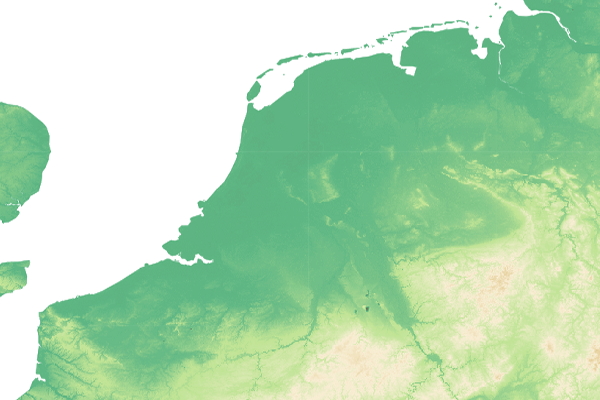

In [6]:
from IPython.display import Image
Image(filename=save_fp)

## Interact with a WFS

OGC Web Feature Service (WFS) can be used to download vector data (called *Features*) from a remote server.
In [Lesson 04 - Vector Data](04-vector-data.ipynb) we have learned that vector data
can come in various formats. With WFS the default format is GML, both "flat", record-like Simple Features,
but also as more complex GML application schema data. Most WFS implementations though, notably GeoServer, will
also allow you to download data in additional vector formats such as GeoJSON and even as ESRI Shapefiles.

When talking about "WFS", the OGC WFS version 1 and 2 is meant. Recently OGC has focused efforts on modernizing the  OWS specifications, which are a total rewrite (using REST, OpenAPI and GeoJSON). As a result, WFS has been rebranded as "OGC API - Features".
This will be treated further below.

The terminology for WFS is different as for WMS. Where WMS has **Layers**, a WFS has equivalent **FeatureTypes** (could even be from the same data, e.g. a database table) basically a collection of **Features**.
 
### GetCapabilities
This is the metadata of the WFS endpoint.


In [7]:
from owslib.wfs import WebFeatureService

wfs_url = 'https://ahocevar.com/geoserver/wfs'

wfs = WebFeatureService(wfs_url, version='2.0.0')

In [8]:
print(f'WFS title: {wfs.identification.title}')

print(f'WFS abstract: {wfs.identification.abstract}')

print(f'Provider name: {wfs.provider.name}')

print(f'Provider address: {wfs.provider.contact.address}')

WFS title: GeoServer Web Feature Service
WFS abstract: Web Feature Service implementation for vector data supporting WFS 1.0.0, WFS 1.1.0 and WFS 2.0.0. All layers published by this service are available via WMS.
Provider name: ahocevar geospatial
Provider address: None


Check the [Capabilities response](https://ahocevar.com/geoserver/wfs?service=WFS&request=GetCapabilities&version=2.0.0) directly from the server

Available operations (services):

In [9]:
[operation.name for operation in wfs.operations]

['GetCapabilities',
 'DescribeFeatureType',
 'GetFeature',
 'GetPropertyValue',
 'ListStoredQueries',
 'DescribeStoredQueries',
 'CreateStoredQuery',
 'DropStoredQuery',
 'ImplementsBasicWFS',
 'ImplementsTransactionalWFS',
 'ImplementsLockingWFS',
 'KVPEncoding',
 'XMLEncoding',
 'SOAPEncoding',
 'ImplementsInheritance',
 'ImplementsRemoteResolve',
 'ImplementsResultPaging',
 'ImplementsStandardJoins',
 'ImplementsSpatialJoins',
 'ImplementsTemporalJoins',
 'ImplementsFeatureVersioning',
 'ManageStoredQueries',
 'PagingIsTransactionSafe',
 'QueryExpressions']

Available WFS FeatureTypes:

In [10]:
list(wfs.contents)

['opengeo:countries',
 'usa:states',
 'w3geo:estrab-msgis-zustand',
 'ne:ne_10m_admin_0_boundary_lines_land',
 'ne:ne_10m_admin_0_countries',
 'ne:ne_10m_admin_1_states_provinces_lines_shp',
 'ne:ne_10m_populated_places',
 'ne:ne_10m_roads',
 'topp:states',
 'osm:water_areas']

As a Feature is basically a (sometime one or more) geometry with attribute data, we would be interested
in the *schema*. For this a WFS provides a `DescribeFeatureType` service. OWSLib provides the method `get_schema()` to effectively call `DescribeFeatureType` on the WFS:

In [11]:
wfs.get_schema('ne:ne_10m_populated_places')

{'properties': {'SCALERANK': 'int',
  'NATSCALE': 'int',
  'LABELRANK': 'int',
  'FEATURECLA': 'string',
  'NAME': 'string',
  'NAMEPAR': 'string',
  'NAMEALT': 'string',
  'DIFFASCII': 'int',
  'NAMEASCII': 'string',
  'ADM0CAP': 'double',
  'CAPALT': 'double',
  'CAPIN': 'string',
  'WORLDCITY': 'double',
  'MEGACITY': 'int',
  'SOV0NAME': 'string',
  'SOV_A3': 'string',
  'ADM0NAME': 'string',
  'ADM0_A3': 'string',
  'ADM1NAME': 'string',
  'ISO_A2': 'string',
  'NOTE': 'string',
  'LATITUDE': 'double',
  'LONGITUDE': 'double',
  'CHANGED': 'double',
  'NAMEDIFF': 'int',
  'DIFFNOTE': 'string',
  'POP_MAX': 'int',
  'POP_MIN': 'int',
  'POP_OTHER': 'int',
  'RANK_MAX': 'int',
  'RANK_MIN': 'int',
  'GEONAMEID': 'double',
  'MEGANAME': 'string',
  'LS_NAME': 'string',
  'LS_MATCH': 'int',
  'CHECKME': 'int',
  'MAX_POP10': 'long',
  'MAX_POP20': 'long',
  'MAX_POP50': 'long',
  'MAX_POP300': 'long',
  'MAX_POP310': 'long',
  'MAX_NATSCA': 'long',
  'MIN_AREAKM': 'long',
  'MAX_AREAK

In [12]:
wfs.contents['usa:states'].boundingBox

(-179.23023299999997,
 17.831509000000036,
 -65.16882499999997,
 71.437769,
 urn:ogc:def:crs:EPSG::4326)

With the `GetFeature` service you can fetch, basically query, for vector data.
This is the key operation of WFS. It is very powerful as well in terms
of its query-options (parameters). You can basically think of a WFS as a web-accessible spatial database.

As a minimum the `typename` parameter is required. Other parameters include:

* `srsname`: fetch (reproject) data according to SRS (usually the EPSG code)
* `bbox`: get the data contained in specified bounding box
* `filter`: this allows you to filter out data, basically like SQL
* `outputFormat`: download the data in various Vector data formats (default GML)

Example. Download all "populated places" within the bounding box of Estonia as GML using the `GetFeature` operation.
Tip: see https://gist.github.com/graydon/11198540 for country bounding boxes.

`OWSLib` will switch the axis order from EN to NE automatically if designated by EPSG-Registry.


In [13]:
response = wfs.getfeature(typename='ne:ne_10m_populated_places', bbox=(23.3397953631, 57.4745283067, 28.1316992531, 59.6110903998))

Now download in a more handy format like GeoJSON (mind: not all WFS-es support alternative output formats!)

In [14]:
response = wfs.getfeature(typename='ne:ne_10m_populated_places', bbox=(23.3397953631, 57.4745283067, 28.1316992531, 59.6110903998), outputFormat='json')
with open('test/10-populated-places-ee.json', 'w', encoding='UTF-8') as out:
	out.write(str(response.read(), 'UTF-8'))

Display data in Notebook or view in browser via [this link](test/10-populated-places-ee.json).

Download GML data using `typename` and `filter` (get only a feature with `NAME=Tartu`). 
OWSLib currently only supports filter building for WFS 1.1 (FE.1.1).

In [15]:
from owslib.fes import PropertyIsLike
from owslib.etree import etree
wfs11 = WebFeatureService(url='https://ahocevar.com/geoserver/wfs?', version='1.1.0')

filter_ = PropertyIsLike(propertyname='NAME', literal='Tartu', wildCard='*')
filterxml = etree.tostring(filter_.toXML()).decode('utf-8')
response = wfs11.getfeature(typename='ne:ne_10m_populated_places', filter=filterxml)

Showing the GML data:

In [16]:
str(response.read(), 'UTF-8')

'<?xml version="1.0" encoding="UTF-8"?><wfs:FeatureCollection xmlns:xs="http://www.w3.org/2001/XMLSchema" xmlns:wfs="http://www.opengis.net/wfs" xmlns:ne="http://naturalearthdata.com" xmlns:gml="http://www.opengis.net/gml" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" numberOfFeatures="1" timeStamp="2024-10-30T10:47:26.591Z" xsi:schemaLocation="http://naturalearthdata.com https://ahocevar.com/geoserver/wfs?service=WFS&amp;version=1.1.0&amp;request=DescribeFeatureType&amp;typeName=ne%3Ane_10m_populated_places http://www.opengis.net/wfs https://ahocevar.com/geoserver/schemas/wfs/1.1.0/wfs.xsd"><gml:featureMembers><ne:ne_10m_populated_places gml:id="ne_10m_populated_places.5903"><ne:the_geom><gml:Point srsName="urn:x-ogc:def:crs:EPSG:4326" srsDimension="2"><gml:pos>58.38394147 26.70988358</gml:pos></gml:Point></ne:the_geom><ne:SCALERANK>6</ne:SCALERANK><ne:NATSCALE>30</ne:NATSCALE><ne:LABELRANK>8</ne:LABELRANK><ne:FEATURECLA>Populated place</ne:FEATURECLA><ne:NAME>Tartu</ne:NAME><

Alternatively as GeoJSON. For you to decide which format is handier...

In [17]:
response = wfs11.getfeature(typename='ne:ne_10m_populated_places', filter=filterxml, outputFormat='json')
json_str = str(response.read(), 'UTF-8')
import json
parsed = json.loads(json_str)
print(json.dumps(parsed, indent=2, sort_keys=True))

{
  "crs": {
    "properties": {
      "name": "urn:ogc:def:crs:EPSG::4326"
    },
    "type": "name"
  },
  "features": [
    {
      "geometry": {
        "coordinates": [
          26.70988358,
          58.38394147
        ],
        "type": "Point"
      },
      "geometry_name": "the_geom",
      "id": "ne_10m_populated_places.5903",
      "properties": {
        "ADM0CAP": 0,
        "ADM0NAME": "Estonia",
        "ADM0_A3": "EST",
        "ADM1NAME": "Tartu",
        "ADMIN1_COD": 18,
        "CAPALT": 0,
        "CAPIN": "",
        "CHANGED": 1,
        "CHECKME": 0,
        "CITYALT": "",
        "COMPARE": 0,
        "DIFFASCII": 0,
        "DIFFNOTE": "Changed scale rank.",
        "ELEVATION": 0,
        "FEATURECLA": "Populated place",
        "FEATURE_CL": "P",
        "FEATURE_CO": "PPLA",
        "GEONAMEID": 588335,
        "GEONAMESNO": "Geonames ascii name + lat.d + long.d matching.",
        "GN_ASCII": "Tartu",
        "GN_POP": 101092,
        "GTOPO30": 37,
   

## Fetch from OGC API Features
Although this may sound very advanced, this is actually one of 
the simpler OGC APIs. See also the [OWSLib Manual for OAFeat](https://owslib.readthedocs.io/en/latest/usage.html#ogc-api).


In [18]:
from owslib.ogcapi.features import Features
oa_feat = Features('https://demo.pygeoapi.io/master')
oa_feat.links

[{'rel': 'about',
  'type': 'text/html',
  'title': 'pygeoapi Demo instance - running latest GitHub version',
  'href': 'https://github.com/geopython/demo.pygeoapi.io/tree/master/services/pygeoapi_master'},
 {'rel': 'self',
  'type': 'application/json',
  'title': 'This document as JSON',
  'href': 'https://demo.pygeoapi.io/master?f=json'},
 {'rel': 'alternate',
  'type': 'application/ld+json',
  'title': 'This document as RDF (JSON-LD)',
  'href': 'https://demo.pygeoapi.io/master?f=jsonld'},
 {'rel': 'alternate',
  'type': 'text/html',
  'title': 'This document as HTML',
  'href': 'https://demo.pygeoapi.io/master?f=html',
  'hreflang': 'en-US'},
 {'rel': 'service-desc',
  'type': 'application/vnd.oai.openapi+json;version=3.0',
  'title': 'The OpenAPI definition as JSON',
  'href': 'https://demo.pygeoapi.io/master/openapi'},
 {'rel': 'service-doc',
  'type': 'text/html',
  'title': 'The OpenAPI definition as HTML',
  'href': 'https://demo.pygeoapi.io/master/openapi?f=html',
  'hreflang

In [19]:
# Open API Specification v3 - API document
api = oa_feat.api() # OpenAPI definition
api

{'components': {'parameters': {'bbox': {'description': 'Only features that have a geometry that intersects the bounding box are selected.The bounding box is provided as four or six numbers, depending on whether the coordinate reference system includes a vertical axis (height or depth).',
    'explode': False,
    'in': 'query',
    'name': 'bbox',
    'required': False,
    'schema': {'items': {'type': 'number'},
     'maxItems': 6,
     'minItems': 4,
     'type': 'array'},
    'style': 'form'},
   'bbox-crs': {'description': 'Indicates the coordinate reference system for the given bbox coordinates.',
    'explode': False,
    'in': 'query',
    'name': 'bbox-crs',
    'required': False,
    'schema': {'format': 'uri', 'type': 'string'},
    'style': 'form'},
   'bbox-crs-epsg': {'description': 'Indicates the EPSG for the given bbox coordinates.',
    'explode': False,
    'in': 'query',
    'name': 'bbox-crs',
    'required': False,
    'schema': {'default': 4326, 'type': 'integer'},

In [20]:
# Conformance stuff
print(f'This OGC API Features endpoint conforms to {oa_feat.conformance()}')

This OGC API Features endpoint conforms to {'conformsTo': ['http://www.opengis.net/spec/ogcapi-common-1/1.0/conf/core', 'http://www.opengis.net/spec/ogcapi-common-1/1.0/conf/html', 'http://www.opengis.net/spec/ogcapi-common-1/1.0/conf/json', 'http://www.opengis.net/spec/ogcapi-common-1/1.0/conf/landing-page', 'http://www.opengis.net/spec/ogcapi-common-1/1.0/conf/oas30', 'http://www.opengis.net/spec/ogcapi-common-2/1.0/conf/collections', 'http://www.opengis.net/spec/ogcapi-coverages-1/1.0/conf/core', 'http://www.opengis.net/spec/ogcapi-coverages-1/1.0/conf/coverage-bbox', 'http://www.opengis.net/spec/ogcapi-coverages-1/1.0/conf/coverage-datetime', 'http://www.opengis.net/spec/ogcapi-coverages-1/1.0/conf/coverage-rangesubset', 'http://www.opengis.net/spec/ogcapi-coverages-1/1.0/conf/coverage-subset', 'http://www.opengis.net/spec/ogcapi-coverages-1/1.0/conf/geodata-coverage', 'http://www.opengis.net/spec/ogcapi-coverages-1/1.0/conf/html', 'http://www.opengis.net/spec/ogcapi-coverages-1/1.

In [21]:
# Get collections (datasets) in endpoint
collections = oa_feat.collections()
print(f'This OGC API Features endpoint has {len(collections)} datasets')

This OGC API Features endpoint has 2 datasets


In [22]:
# Get items (paged) in Lakes collection
lakes = oa_feat.collection('lakes')
lakes_query = oa_feat.collection_items('lakes')
lakes_query['features'][0]

{'type': 'Feature',
 'properties': {'id': 0,
  'scalerank': 0,
  'name': 'Lake Baikal',
  'name_alt': 'https://en.wikipedia.org/wiki/Lake_Baikal',
  'admin': None,
  'featureclass': 'Lake'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[106.57998579307912, 52.79998159444554],
    [106.53998823448521, 52.93999888774037],
    [107.0800069519353, 53.18001007751998],
    [107.2999935242018, 53.37999787048953],
    [107.59997521365611, 53.51998932556822],
    [108.03994835818912, 53.859968573616456],
    [108.37997928266967, 54.25999583598784],
    [109.05270307824526, 55.027597561251326],
    [109.19346967980832, 55.53560272889659],
    [109.50699059452313, 55.73091380474372],
    [109.92980716353523, 55.7129562445223],
    [109.70000206913326, 54.980003567110515],
    [109.66000451053935, 54.71999359803395],
    [109.47996382043448, 54.33999095317566],
    [109.31997358605884, 53.81999685323869],
    [109.22003136600637, 53.619983222052994],
    [108.99999311730755, 53.780025132860

## Searching for the data in CSW server - OPTIONAL
This last section is quite advanced, you may want to skip if
time pressures.

We will use a metadata service (CSW) to find our target 
data service, a regular WFS (v2). All via OWSLib.

### Step 1 - Find WFS endpoints by querying a CSW endpoint

First step: let's find some WFS service in our CSW server:
NOTE: You can skip this step and use the URL directly


In [23]:
from owslib.fes import PropertyIsLike, BBox, And, PropertyIsEqualTo
from owslib.csw import CatalogueServiceWeb

thecsw = CatalogueServiceWeb('http://geoportal.gov.cz/php/micka/csw/index.php')

In [24]:
# wfs_query = PropertyIsLike('csw:AnyText', 'WFS')
geology_query = PropertyIsLike('csw:AnyText', 'Geology')
service_query = PropertyIsLike('apiso:type', 'service')
geology_and_wfs = And([geology_query, service_query])
thecsw.getrecords2([geology_and_wfs], esn='full')

print(thecsw.results)

{'matches': 76, 'returned': 10, 'nextrecord': 11}


In [25]:
for recid in thecsw.records:
    record = thecsw.records[recid]
    print(recid, record.title)

575a4ef6-2f74-43ed-9352-6f400a010852 ČGS Podložní a povrchová geologie – OneGeology-Europe (anglická verze)
5d80e27a-2794-4b8d-8af4-33410a010852 Doplňky Geologické mapy 1 : 50 000 (GEOČR50)
5be1752f-85dc-4b5c-941a-2dfa0a010852 Exkurzní průvodce (optimalizováno pro mobilní zařízení)
63a4566f-5094-48e5-8dc1-5c280a010852 Geoelektrika – Vertikální elektrické sondování (VES) – INSPIRE prohlížecí služba (téma Geologie)
5e0e1ce1-8328-47cb-a44a-63300a010852 Geoelektrika - Vertikální elektrické sondování (VES) – INSPIRE stahovací služba (téma Geologie)
5c1a2a44-e8f4-4fcb-b223-0cb90a010852 Geofyzikální měření (prozkoumanost, gravimetrie, seismika, VES)
60913439-23dc-488e-9858-46210a010852 Geofyzikální měření (prozkoumanost, gravimetrie, seismika, VES)
5ad0bad7-44a4-4f8a-9d4c-313a0a010852 Geofyzikální prozkoumanost
63a44ce9-9c0c-4eab-a92b-67260a010852 Geofyzikální prozkoumanost – INSPIRE prohlížecí služba (téma Geologie)
5e0e12df-f0f4-4eb8-a7be-5d4a0a010852 Geofyzikální prozkoumanost – INSPIRE st

### Step 2 - Get the WFS endpoint and interact with it
Let's have a look at WFS data in czech Geology survey.

In [26]:
geology = thecsw.records['575a4ef6-2f74-43ed-9352-6f400a010852']
print(f'Abstract: {geology.abstract}')

print(f'Identifier: {geology.identifiers[1]["identifier"]}')

Abstract: INSPIRE prohlížecí služba zobrazující datovou sadu GeoCR500, která byla vytvořena pro účely projektu OneGeology-Europe. Aktualizovaná v rámci projektu EGDI v roce 2016.
Identifier: http://inspire.geology.cz/geoserver/wms?service=WMS&version=1.3.0&request=Getcapabilities


In [27]:
from owslib.wfs import WebFeatureService
url = 'http://inspire.geology.cz/geoserver/wms?service=WMS&version=1.3.0&request=Getcapabilities'
geology_wfs = WebFeatureService(geology.identifiers[1]['identifier'])

Service metadata (Capabilities):

In [28]:
capabilities = geology_wfs.getcapabilities()
print(f'URL: {capabilities.geturl()}')
print(f'Name: {geology_wfs.provider.name}')
print(f'Title: {geology_wfs.identification.title}')
print(f'Keywords: {geology_wfs.identification.keywords[0]}')
print(f'Fees: {geology_wfs.identification.fees}')
print(f'Abstract: {geology_wfs.identification.abstract}')

URL: http://inspire.geology.cz/geoserver/wms?service=WFS&request=GetCapabilities&version=1.0.0
Name: WFS
Title: Mapové služby geoserveru České geologické služby-WFS
Keywords: WFS, WMS, GEOSERVER
Fees: NONE
Abstract: Mapvé služby České geologické služby publikované pomocí geoserveru jsou převážně určeny pro mezinárodní projekty, které vyžadují specifická řešení a nelze při nich použít standardních služeb publikovaných na mapovém serveru České geologické služby (http://mapy.geology.cz)


Print list of available layers 

In [29]:
for i in geology_wfs.contents:
    print(f'\n#### {i} ####')
    print(geology_wfs.contents[i].abstract)


#### gsmlp:CZE_CGS_500k_Fault ####
MappedFeature (spatial objects) whose specification property is of type Geologic structure

#### gsmlp:CZE_CGS_500k_Geology_AGE ####
MappedFeature (spatial objects) whose specification property is of type GeologicUnit.

#### gsmlp:CZE_CGS_500k_Geology_Lito ####
MappedFeature (spatial objects) whose specification property is of type GeologicUnit.

#### ge:GeologicStructure ####
-- Definition --
  Structure
  
  -- Description --
  Legend ...
  Spatial properties are only available through association with a MappedFeature.

#### ge:GeologicUnit ####
-- Definition --
  A volume of rock with distinct characteristics.
  
  -- Description --
  Includes both formal units (i.e. formally adopted and named in an official lexicon) and informal units (i.e. named but not promoted to the lexicon) and unnamed units (i.e. recognisable and described and delineable in the field but not otherwise formalised).
  Spatial properties are only available through association 

Download data from selected layer and write to a file.

In [30]:
identifier = 'gsmlp:CZE_CGS_500k_Fault'
features = geology_wfs.getfeature([identifier])

with open('test/10-geology-faults.gml', 'w', encoding='UTF-8') as out:
    out.write(str(features.read(), 'UTF-8'))

View the GML-data in browser via [this link](test/10-geology-faults.gml).

---
[<- Publishing](09-publishing.ipynb) | [Emerging technology and trends ->](11-emerging-technology-trends.ipynb)